# Optimizing Super Resolution Model

The goal of this experiment is to try training the exisiting server model using the PSNR metric, which appears to be the standard for measuring image quality.

The model is trained in google's colaboatory environmnent, using their provided GPU.

## Helper functions

### Mount Colab

In [0]:
# load google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Build Dataset

In [0]:
from tqdm import tqdm

# fetches image filenames
def get_filenames(directory):
	for _,_,filenames in os.walk(directory):
		pass
	return filenames

# returns dataset in (x_train, y_train), (x_test, y_test) format
def build_dataset(directory):
	# initialize variables
	filenames = get_filenames(directory)
	X = []
	Y = []

	# collect images from directory
	for filename in tqdm(filenames):
		# print("Processing", filename)
		image = Image.open(directory + filename)
		image_large = np.array(image)
		image_small = np.array(image.resize((150,150)))
		Y.append(image_large)
		X.append(image_small)

	# convert to matrices
	X = np.asarray(X)
	X = X.astype('float32')
	X /= 255
	Y = np.asarray(Y)
	Y = Y.astype('float32')
	Y /= 255

	x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

	# following keras convention for load_data() 
	return ((x_train, y_train), (x_test, y_test))

### Plots and results display functions

In [0]:
# show results of a trained model 
def display_results(model, n=10, img_size=10):
	if n > 1:
		fig, axs = plt.subplots(n, 3, figsize=(3 * img_size, n * img_size))
		for index, ax in enumerate(axs):
			ax[0].imshow(x_test[index])
			ax[0].axis('off')
			ax[1].imshow(y_test[index])
			ax[1].axis('off')
			y_pred = model.predict(x_test[index:index+1])[0]
			ax[2].imshow(y_pred)
			ax[2].axis('off')
		plt.show()
	else:
		print("n must be at least 2")

# plot accuracy and error over epochs
def display_error_plots(hist):
	if type(hist) == tf.keras.callbacks.History:
		acc = hist.history['PSNR']
		val_acc = hist.history['val_PSNR']
		loss = hist.history['loss']
		val_loss = hist.history['val_loss']

		fig, axs = plt.subplots(1,2, figsize=(15,5))
		axs[0].plot(acc, label='Training accuracy')
		axs[0].plot(val_acc, label='Validation accuracy')
		axs[0].legend(loc='lower right')
		axs[0].set_title("Accuracy")
		axs[1].plot(loss, label='Training error')
		axs[1].plot(val_loss, label='Validation error')
		axs[1].legend()
		axs[1].set_title("Error")
		plt.show()
	else:
		raise TypeError("Expected object of type keras.callbacks.History not " + type(hist).__name__)

## Experiments

### Imports and Dataset

In [0]:
# imports
from google.colab import files
import tensorflow as tf

from tensorflow.keras.layers import Conv2D, UpSampling2D, Input, Add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l1_l2, l1
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from numpy.random import randint
import numpy as np
import os

In [0]:
# get dataset
directory = 'gdrive/My Drive/Projects/Data Science/Super Resolution/dataset/downscaled/'
(x_train, y_train), (x_test, y_test) = build_dataset(directory)

100%|██████████| 1087/1087 [00:07<00:00, 149.80it/s]


### Experiment 2: Applying PSNR and observing results

#### Training

In [0]:
def conv_block(input_layer, num_filters=64, activation='relu', kernel_size=(3,3)):
  conv1 = Conv2D(num_filters, kernel_size, padding='same', activation=activation, activity_regularizer=l1(0.01))(input_layer)
  conv2 = Conv2D(num_filters, kernel_size, padding='same', activation=activation, activity_regularizer=l1(0.01))(conv1)
  conv2_1 = Conv2D(3, (1,1), padding='same')(conv2)
  return Add()([conv2_1, input_layer])

In [0]:
# hyperparameters
num_epochs = 60
batch_size = 128
num_filters = 128
num_pool = 2
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [0]:
input_layer1 = Input(shape=(None,None,3))
input_layer2 = conv_block(input_layer1)
input_layer3 = conv_block(input_layer2)
input_layer4 = conv_block(input_layer3)
input_layer5 = conv_block(input_layer4)
input_layer6 = conv_block(input_layer5)
upsampled = UpSampling2D(size=(2,2))(input_layer6)
conv5 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(upsampled)
conv6 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(conv5)
conv7 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(conv6)
conv8 = Conv2D(num_filters, (3,3), padding='same', activation='relu')(conv7)
output = Conv2D(3, (1,1), padding='same')(conv8)
model = Model(inputs=input_layer1, outputs=output)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_140 (Conv2D)             (None, None, None, 6 1792        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_141 (Conv2D)             (None, None, None, 6 36928       conv2d_140[0][0]                 
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, None, None, 3 195         conv2d_141[0][0]                 
____________________________________________________________________________________________

In [0]:
from keras import backend as K

def PSNR(y_true, y_pred):
    max_pixel = 1.0
    return (10.0 * K.log((max_pixel ** 2) / (K.mean(K.square(y_pred - y_true), axis=-1)))) / 2.303

In [0]:
# compile model
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=[PSNR])

In [0]:
# train model
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(x_test, y_test))

Train on 869 samples, validate on 218 samples
Epoch 1/60
869/869 [==============================] - 162s 187ms/sample - loss: 3196.0115 - PSNR: 18.1348 - val_loss: 1845.6370 - val_PSNR: 22.3370
Epoch 2/60
869/869 [==============================] - 161s 185ms/sample - loss: 1679.6183 - PSNR: 25.3071 - val_loss: 1346.9832 - val_PSNR: 28.1263
Epoch 3/60
869/869 [==============================] - 161s 185ms/sample - loss: 1243.1505 - PSNR: 29.2584 - val_loss: 972.2734 - val_PSNR: 31.1622
Epoch 4/60
869/869 [==============================] - 161s 185ms/sample - loss: 794.2873 - PSNR: 31.1497 - val_loss: 454.0466 - val_PSNR: 28.6155
Epoch 5/60
869/869 [==============================] - 161s 185ms/sample - loss: 266.8549 - PSNR: 31.1203 - val_loss: 126.2924 - val_PSNR: 30.7582
Epoch 6/60
869/869 [==============================] - 161s 185ms/sample - loss: 94.3922 - PSNR: 31.7021 - val_loss: 64.2810 - val_PSNR: 34.0554
Epoch 7/60
869/869 [==============================] - 161s 186ms/sample - l

#### Results seem quite a bit better than using accuracy


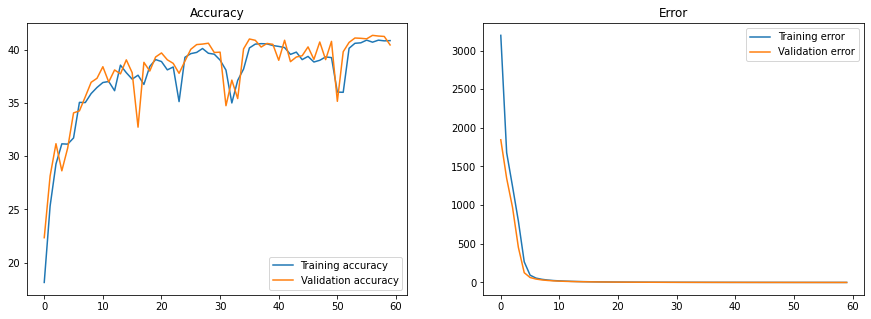

In [0]:
display_error_plots(hist)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


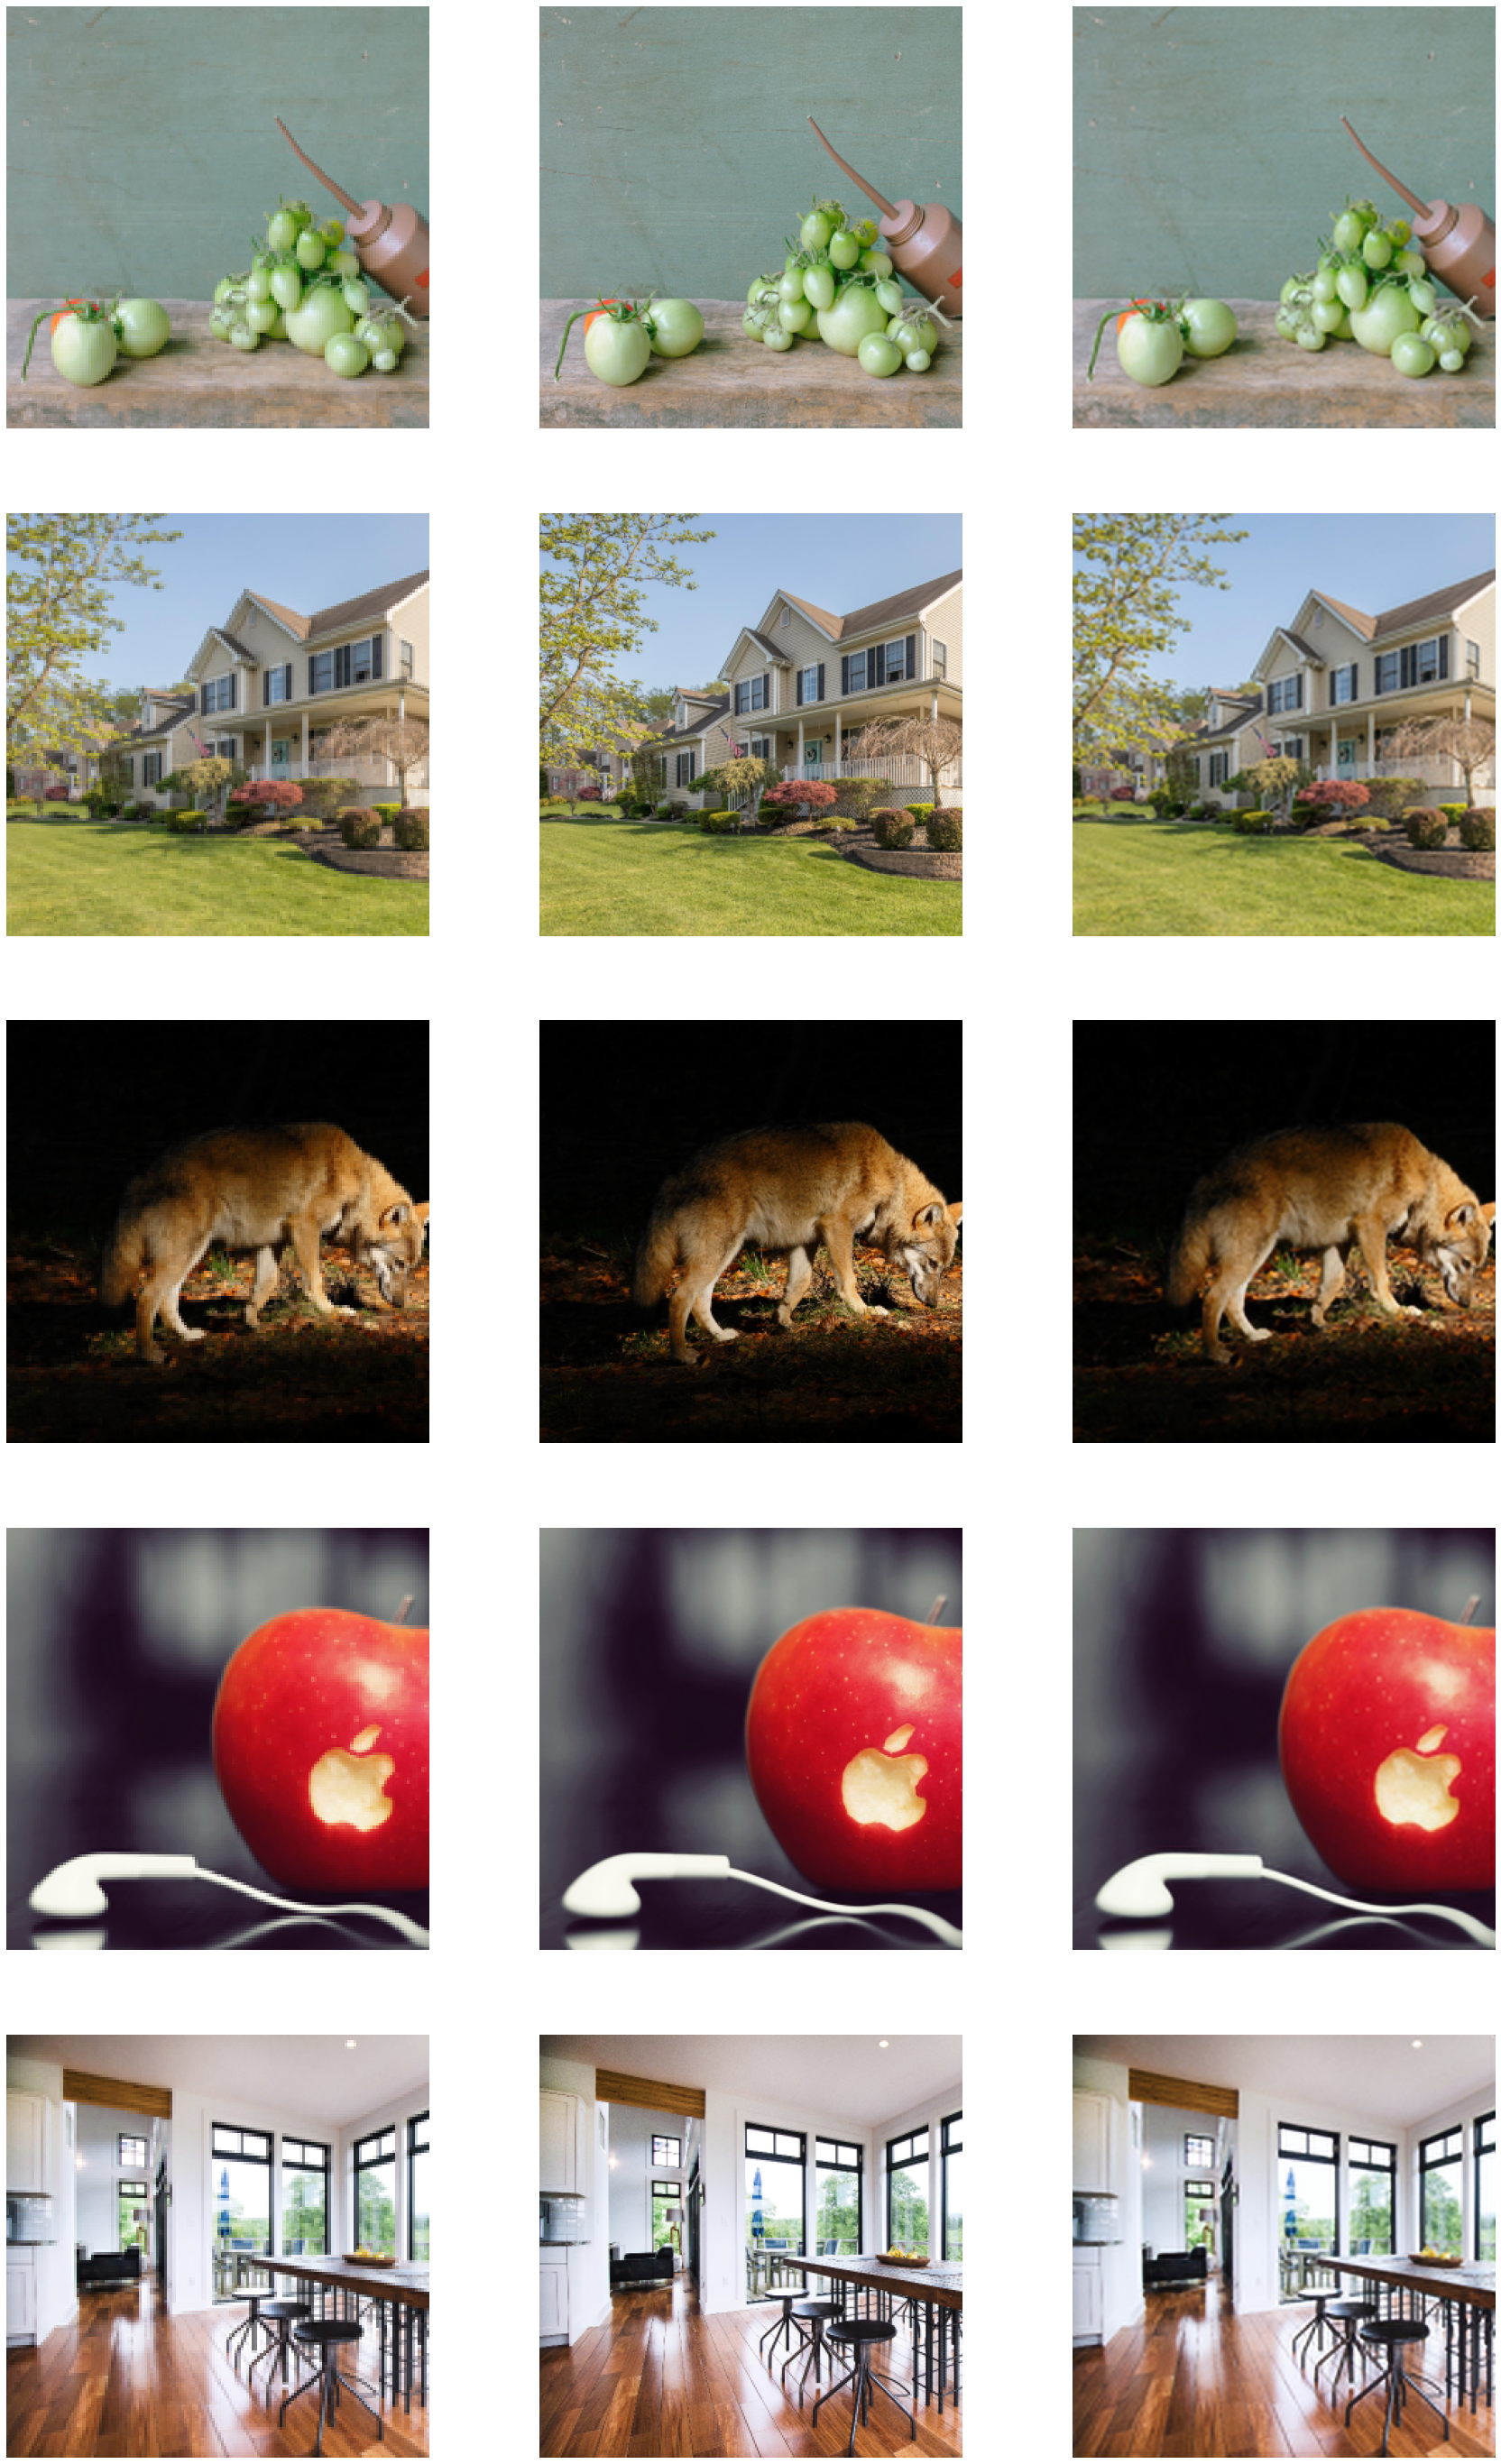

In [0]:
display_results(model, n=5)